# 权重衰减

**权重衰减等价于L2正则化**

正则化通过为模型损失函数添加惩罚项使学到的模型参数较小，是应对模型过拟合的常用手段。

$L_2$范数惩罚项指的是模型权重参数的每个元素的平方和与一个正常数的乘积

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import utils as d2l

## dataset

In [2]:
num_train, num_test = 20, 100
num_inputs = 100
true_w = torch.ones(num_inputs) * 0.01
true_b = 0.05

features = torch.randn((num_train + num_test, num_inputs))

labels = torch.matmul(features, true_w.view(num_inputs, 1)) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # add noise

train_features, test_features = features[:num_train, :], features[num_train:, :]
train_labels, test_labels = labels[:num_train], labels[num_train:]

In [3]:
print(true_w, true_b)
print(train_features[0], train_labels[1])

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100]) 0.05
tensor([ 0.0673,  1.4468,  1.0303, -0.1125, -1.3165, -0.8629,  0.1114, -1.1015,
         0.5399, -

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(6, 4)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

## model

In [5]:
# initial model parameter
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [6]:
# l2 penalty item
def l2_loss(w, lambd=0.0):
    return lambd * (w ** 2).sum()

In [7]:
# linear regression
def linear_regression(x, w, b):
    
    return torch.mm(x, w) + b

In [8]:
# mean squre erros
def mse_loss(y_pred, y):
    
    squred_loss = (y_pred - y.view(y_pred.size())) ** 2
    return squred_loss.mean()

In [9]:
# sgd optimizer
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [10]:
# config
batch_size = 2
lr = 0.002
num_epochs = 100

loss = mse_loss

train_data = data.TensorDataset(train_features, train_labels)
train_generator = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

## training with custom function

In [11]:
# custom 
def fit_and_plot(lambd):
    
    net = linear_regression
    
    # init params
    w, b = init_params()
    train_loss, test_loss = [], []
    for _ in range(num_epochs):
        for x, y in train_generator:
            pred_y = net(x, w, b)
            # loss + l2_loss
            l = mse_loss(pred_y, y) + l2_loss(w, lambd)
            l = l.sum()
            
            # grad clearing
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            
            # backward
            l.backward()
            
            # update grad
            sgd([w, b], lr, batch_size)
            
        train_loss.append(loss(net(train_features, w, b), train_labels).mean().item()) # train loss
        test_loss.append(loss(net(test_features, w, b), test_labels).mean().item()) # test loss
        
    semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_loss, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

### not use l2 loss

L2 norm of w: 9.573019027709961


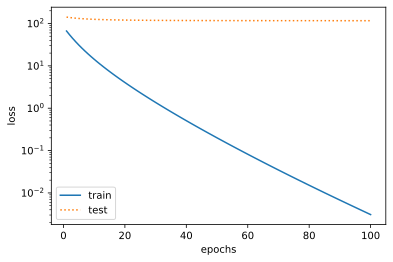

In [12]:
fit_and_plot(lambd=0)

## use l2 loss

L2 norm of w: 0.034309446811676025


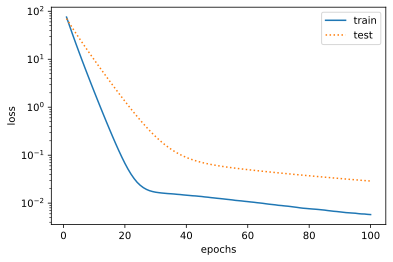

In [13]:
fit_and_plot(lambd=5)

## training with pytorch

pytorch 在构造优化器时通过**weight_decay**参数指定权重衰减超参数

In [14]:
# use pytorch interface
def fit_and_plot_pytorch(lambd):
    # net
    net = nn.Linear(num_inputs, 1)
    # loss
    # loss = nn.MSELoss()
    # init params
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=lambd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减

    train_loss, test_loss = [], []
    for _ in range(num_epochs):
        for x, y in train_generator:
            l = loss(net(x), y)
            # grad clearing
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_loss.append(loss(net(train_features), train_labels).mean().item())
        test_loss.append(loss(net(test_features), test_labels).mean().item())
        
    semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'loss',
             range(1, num_epochs + 1), test_loss, ['train', 'test'])
    
    print('L2 norm of w:', net.weight.data.norm().item())

### not use l2 loss

L2 norm of w: 8.151586532592773


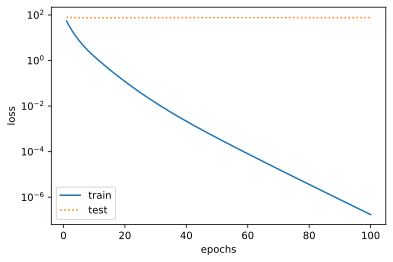

In [15]:
fit_and_plot_pytorch(lambd=0)

In [16]:
### use l2 loss

L2 norm of w: 0.1163228452205658


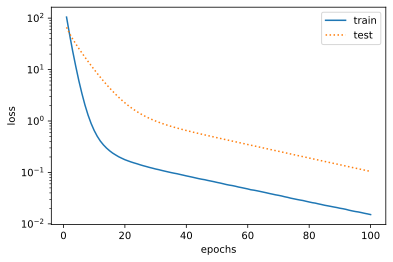

In [17]:
fit_and_plot_pytorch(lambd=5)